# Gorilla Data Engineer Assessment
## Setup

In [1]:
import platform

print(platform.python_version())

3.11.4


In [17]:
!pip freeze | grep -f requirements.txt

jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.9.0
jupyter-lsp==2.2.1
jupyter_client==8.6.0
jupyter_core==5.5.0
jupyter_server==2.11.1
jupyter_server_terminals==0.4.4
jupyterlab==4.0.9
jupyterlab-widgets==3.0.9
jupyterlab_pygments==0.3.0
jupyterlab_server==2.25.2
matplotlib==3.8.2
matplotlib-inline==0.1.6
numpy==1.26.2
openpyxl==3.1.2
pandas==2.1.3
seaborn==0.13.0


## Load data

In [102]:
import pandas as pd
import numpy as np
from datetime import datetime

df_meter_list = pd.read_excel(r'data/gorilla_test_data.xlsx', sheet_name='meter_list')
df_forecast_table = pd.read_excel(r'data/gorilla_test_data.xlsx', sheet_name='forecast_table')
df_rate_table = pd.read_excel(r'data/gorilla_test_data.xlsx', sheet_name='rate_table')

In [39]:
df_meter_list.head()

,meter_id,aq_kwh,exit_zone
0,14676236,28978,EA1
1,34509937,78324,SO1
2,50264822,265667,NT1
3,88357331,484399,SE2


In [48]:
df_forecast_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   meter_id  3412 non-null   int64         
 1   date      3412 non-null   datetime64[ns]
 2   kwh       3412 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 80.1 KB


In [37]:
df_forecast_table.groupby('meter_id')['date'].agg(['min', 'max'])

,min,max
meter_id,,
14676236,2020-06-01,2022-10-01
34509937,2020-06-01,2022-10-01
50264822,2020-06-01,2022-10-01
88357331,2020-06-01,2022-10-01


In [28]:
df_rate_table.head()

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
2,2020-04-01,EA1,732000,NaN,0.2875
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524


## Exercise 1: Total Estimated Consumption and Total Cost

In [70]:
total_consumption = df_forecast_table.groupby('meter_id')[['kwh']].sum()
total_consumption
# total sum equals aq_kwh column in df_meter_list

,kwh
meter_id,
14676236,28978.0
34509937,78324.0
50264822,265667.0
88357331,484399.0


In [63]:
# calculate end date of period (+6m of start date)
df_rate_table = df_rate_table.rename(columns={'date': 'date_start'})
df_rate_table['date_end'] = df_rate_table['date_start'] + pd.offsets.DateOffset(months=6)
df_rate_table

,date_start,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh,date_end
0,2020-04-01,EA1,0,73200.0,0.2652,2020-10-01
1,2020-04-01,EA1,73200,732000.0,0.1980,2020-10-01
2,2020-04-01,EA1,732000,NaN,0.2875,2020-10-01
3,2020-04-01,EA2,0,73200.0,0.2970,2020-10-01
4,2020-04-01,EA2,73200,732000.0,0.1524,2020-10-01
...,...,...,...,...,...,...
1135,2024-10-01,WM2,73200,732000.0,0.4537,2025-04-01
1136,2024-10-01,WM2,732000,NaN,0.7534,2025-04-01
1137,2024-10-01,WM3,0,73200.0,0.7263,2025-04-01
1138,2024-10-01,WM3,73200,732000.0,0.6109,2025-04-01


In [68]:
df_large = df_forecast_table.merge(df_meter_list, on='meter_id').merge(df_rate_table, on=['exit_zone'])

# fill in NaN for aq_max_kwh maximum of (aq_kwh + 1) and aq_min_kwh
df_large['aq_max_kwh_clean'] = np.maximum(df_large.aq_min_kwh, df_large.aq_max_kwh.fillna(df_large.aq_kwh + 1))
df_large

,meter_id,date,kwh,aq_kwh,exit_zone,date_start,aq_min_kwh,aq_max_kwh,rate_p_per_kwh,date_end,aq_max_kwh_clean
0,14676236,2020-06-01,22.070768,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0
1,14676236,2020-06-01,22.070768,28978,EA1,2020-04-01,73200,732000.0,0.1980,2020-10-01,732000.0
2,14676236,2020-06-01,22.070768,28978,EA1,2020-04-01,732000,NaN,0.2875,2020-10-01,732000.0
3,14676236,2020-06-01,22.070768,28978,EA1,2020-10-01,0,73200.0,0.2970,2021-04-01,73200.0
4,14676236,2020-06-01,22.070768,28978,EA1,2020-10-01,73200,732000.0,0.2218,2021-04-01,732000.0
...,...,...,...,...,...,...,...,...,...,...,...
102355,88357331,2022-10-01,460.535505,484399,SE2,2024-04-01,73200,732000.0,0.5739,2024-10-01,732000.0
102356,88357331,2022-10-01,460.535505,484399,SE2,2024-04-01,732000,NaN,0.5717,2024-10-01,732000.0
102357,88357331,2022-10-01,460.535505,484399,SE2,2024-10-01,0,73200.0,0.6015,2025-04-01,73200.0
102358,88357331,2022-10-01,460.535505,484399,SE2,2024-10-01,73200,732000.0,0.6428,2025-04-01,732000.0


In [74]:

# filter for correct period
df_large_period_filtered = df_large[np.logical_and(df_large.date >= df_large.date_start,
                                                   df_large.date < df_large.date_end)]
# filter for correct AQ band
df = df_large_period_filtered[np.logical_and(df_large_period_filtered.aq_kwh >= df_large_period_filtered.aq_min_kwh,
                                             df_large_period_filtered.aq_kwh < df_large_period_filtered.aq_max_kwh_clean)]
df

,meter_id,date,kwh,aq_kwh,exit_zone,date_start,aq_min_kwh,aq_max_kwh,rate_p_per_kwh,date_end,aq_max_kwh_clean
0,14676236,2020-06-01,22.070768,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0
30,14676236,2020-06-02,19.170720,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0
60,14676236,2020-06-03,23.555111,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0
90,14676236,2020-06-04,18.220712,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0
120,14676236,2020-06-05,14.196134,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0
...,...,...,...,...,...,...,...,...,...,...,...
102223,88357331,2022-09-27,441.014725,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0
102253,88357331,2022-09-28,441.512055,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0
102283,88357331,2022-09-29,437.240657,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0
102313,88357331,2022-09-30,517.608354,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0


In [75]:
# calculate cost
df['cost_pound'] = df.kwh * df.rate_p_per_kwh / 100
df

/var/folders/r4/13_py2jj2ybgk5_1_92hr8kr0000gn/T/ipykernel_83184/3672623622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cost_pound'] = df.kwh * df.rate_p_per_kwh / 100


,meter_id,date,kwh,aq_kwh,exit_zone,date_start,aq_min_kwh,aq_max_kwh,rate_p_per_kwh,date_end,aq_max_kwh_clean,cost_pound
0,14676236,2020-06-01,22.070768,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0,0.058532
30,14676236,2020-06-02,19.170720,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0,0.050841
60,14676236,2020-06-03,23.555111,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0,0.062468
90,14676236,2020-06-04,18.220712,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0,0.048321
120,14676236,2020-06-05,14.196134,28978,EA1,2020-04-01,0,73200.0,0.2652,2020-10-01,73200.0,0.037648
...,...,...,...,...,...,...,...,...,...,...,...,...
102223,88357331,2022-09-27,441.014725,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0,1.608381
102253,88357331,2022-09-28,441.512055,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0,1.610194
102283,88357331,2022-09-29,437.240657,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0,1.594617
102313,88357331,2022-09-30,517.608354,484399,SE2,2022-04-01,73200,732000.0,0.3647,2022-10-01,732000.0,1.887718


In [80]:
# Result table exercise 1
df.groupby('meter_id')[['kwh', 'cost_pound']].sum().round(2).rename(columns={'meter_id': 'Meter ID', 'kwh': 'Total Estimated Consumption (kWh)', 'cost_pound': 'Total Cost (£)'})

,Total Estimated Consumption (kWh),Total Cost (£)
meter_id,,
14676236,28978.0,100.15
34509937,78324.0,275.49
50264822,265667.0,731.24
88357331,484399.0,1433.16


## Exercise 2: Random meter generator

In [96]:
def random_meter_list(n: int) -> pd.DataFrame:
    return pd.DataFrame(np.array([np.random.randint(1e8, 1e9, size=n),
                         np.random.randint(25e3, 5e5, size=n),
                         np.random.choice(df_rate_table.exit_zone.unique(), size=n)]).T, columns=df_meter_list.columns)

In [98]:
random_meter_list(5)

,meter_id,aq_kwh,exit_zone
0,270874881,125229,LC
1,750062885,445097,NO2
2,831866923,227405,NO1
3,623055754,440923,WA1
4,403701922,415986,EA2


## Exercise 3: Mock consumption data generator

In [116]:
def mock_consumption_data(meter_list: pd.DataFrame, start_date: datetime, duration_in_days: int) -> pd.DataFrame:
    date = pd.date_range(start_date, start_date + pd.offsets.DateOffset(days=duration_in_days), inclusive='left')
    mock_data = []
    for meter in meter_list['meter_id']:
        mock_data.append(pd.DataFrame({'meter_id': [meter]*duration_in_days,
                                       'date': date,
                                       'kwh': np.random.rand(duration_in_days) * 1100 + 2.5}))
    return pd.concat(mock_data)

In [122]:
mock_consumption_data(random_meter_list(5), start_date=datetime(2020,1,1), duration_in_days=5)

,meter_id,date,kwh
0,464226811,2020-01-01,964.529330
1,464226811,2020-01-02,307.737341
2,464226811,2020-01-03,956.953990
3,464226811,2020-01-04,133.196963
4,464226811,2020-01-05,1083.531727
0,160012012,2020-01-01,686.177189
1,160012012,2020-01-02,719.206603
2,160012012,2020-01-03,211.526593
3,160012012,2020-01-04,743.593638
4,160012012,2020-01-05,445.958985


## Exercise 4: Cost table generator + benchmarking

In [128]:
def cost_table(meter_list: pd.DataFrame, consumption_data: pd.DataFrame, rate_table: pd.DataFrame) -> pd.DataFrame:
    df = consumption_data.merge(meter_list, on='meter_id').merge(rate_table, on=['exit_zone'])

    # fill in NaN for aq_max_kwh maximum of (aq_kwh + 1) and aq_min_kwh
    df['aq_max_kwh_clean'] = np.maximum(df.aq_min_kwh, df.aq_max_kwh.fillna(df.aq_kwh + 1))

    # filter for correct period
    df = df[np.logical_and(df.date_x >= df.date_y,
                           df.date_x < df.date_y + pd.offsets.DateOffset(months=6))]

    # filter for correct AQ band
    df = df[np.logical_and(df.aq_kwh >= df.aq_min_kwh,
                           df.aq_kwh < df.aq_max_kwh_clean)]

    # calculate cost in pounds per day
    df['cost_pound'] = df.kwh * df.rate_p_per_kwh / 100

    # Sum over period per meter
    return df.groupby('meter_id')[['kwh', 'cost_pound']].sum().round(2).rename(columns={'meter_id': 'Meter ID', 'kwh': 'Total Estimated Consumption (kWh)', 'cost_pound': 'Total Cost (£)'})

In [146]:
# raw rate_table is sufficient, no need to calculate end date previously
df_rate_table = pd.read_excel(r'data/gorilla_test_data.xlsx', sheet_name='rate_table')

In [147]:
meter_list = random_meter_list(5)
consumption_data = mock_consumption_data(meter_list, start_date=datetime(2020, 6, 1), duration_in_days=365)
cost_table(meter_list=meter_list,
           consumption_data=consumption_data,
           rate_table=df_rate_table)

,Total Estimated Consumption (kWh),Total Cost (£)
meter_id,,
106113271,200397.51,336.97
121406307,203033.38,371.58
579579422,200996.37,650.34
623908668,196506.23,606.81
874125455,195286.73,352.84


### Benchmarking

In [145]:
def benchmark_cost_table_generation(n_meters: int, n_days: int, rate_table: pd.DataFrame) -> datetime:
    meter_list = random_meter_list(n_meters)
    consumption_data = mock_consumption_data(meter_list, start_date=datetime(2020, 6, 1), duration_in_days=n_days)

    t1 = datetime.now()
    cost_table(meter_list=meter_list,
               consumption_data=consumption_data,
               rate_table=rate_table)
    t2 = datetime.now()
    return t2-t1

In [213]:
# variable: number of meters
# fixed: duration = 365 days

n_meters = np.logspace(np.log10(5),np.log10(1000),25).astype(int)
time_delta_n_meter_variable = []

print('Variable n_meters:')
for n in n_meters:
    delta = benchmark_cost_table_generation(n, n_days=365, rate_table=df_rate_table)
    print(f'{n}: {delta}')
    time_delta_n_meter_variable.append(delta.total_seconds())

Variable n_meters:
5: 0:00:00.019047
6: 0:00:00.020800
7: 0:00:00.022015
9: 0:00:00.029384
12: 0:00:00.039367
15: 0:00:00.046958
18: 0:00:00.057892
23: 0:00:00.069750
29: 0:00:00.091582
36: 0:00:00.112293
45: 0:00:00.140573
56: 0:00:00.174699
70: 0:00:00.223279
88: 0:00:00.277811
109: 0:00:00.357408
137: 0:00:00.434225
170: 0:00:00.515965
213: 0:00:00.619933
265: 0:00:00.760825
331: 0:00:00.945022
413: 0:00:01.206729
515: 0:00:01.505542
643: 0:00:01.842359
801: 0:00:02.243208
1000: 0:00:02.775057


In [211]:
# variable: number of days
# fixed: number of meters = 20

n_days = np.arange(365, 365*20+1, 365)
time_delta_n_days_variable = []

print('\nVariable n_days:')
for n in n_days:
    delta = benchmark_cost_table_generation(n_meters=20, n_days=n, rate_table=df_rate_table)
    print(f'{n}: {delta}')
    time_delta_n_days_variable.append(delta.total_seconds())



Variable n_days:
365: 0:00:00.064713
730: 0:00:00.129772
1095: 0:00:00.186559
1460: 0:00:00.281255
1825: 0:00:00.303185
2190: 0:00:00.355938
2555: 0:00:00.408457
2920: 0:00:00.476818
3285: 0:00:00.610379
3650: 0:00:00.571178
4015: 0:00:00.661816
4380: 0:00:00.664281
4745: 0:00:00.821790
5110: 0:00:00.807729
5475: 0:00:00.816656
5840: 0:00:00.992645
6205: 0:00:00.917340
6570: 0:00:00.955149
6935: 0:00:01.012073
7300: 0:00:01.065659


In [214]:
def regress(x, y, axis=0):
    x = x.copy()
    y = y.copy()
    sx = np.nansum(x, axis=axis)
    sy = np.nansum(y, axis=axis)
    sxy = np.nansum((x * y), axis=axis)
    sxq = np.nansum(x * x, axis=axis)
    N = np.nansum(np.isfinite(x), axis=axis)
    m = (N * sxy - sx * sy) / (N * sxq - sx ** 2)
    b = (sy - m * sx) / N
    return m,b

# calculate slope of computation time
m_meter, b_meter = regress(n_meters, time_delta_n_meter_variable)
m_day, b_day = regress(n_days, time_delta_n_days_variable)


In [215]:
computation_forecast = lambda n_meters, n_days: (m_meter + m_day) * n_meters + (b_meter + b_day)

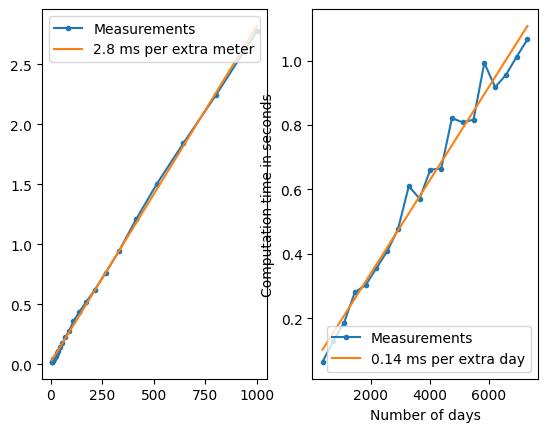

In [217]:
import matplotlib.pyplot as plt

fig, (ax_meters, ax_days) = plt.subplots(1,2)

ax_meters.plot(n_meters, time_delta_n_meter_variable, '.-', label='Measurements')
ax_meters.plot(n_meters, m_meter*n_meters+b_meter, '-', label=f'{np.round(m_meter*1000,2)} ms per extra meter')
plt.xlabel('Number of meters')
plt.ylabel('Computation time in seconds')
ax_meters.legend()

ax_days.plot(n_days, time_delta_n_days_variable, '.-', label='Measurements')
ax_days.plot(n_days, m_day*n_days+b_day, '-', label=f'{np.round(m_day*1000,2)} ms per extra day')
plt.xlabel('Number of days')
plt.ylabel('Computation time in seconds')
ax_days.legend()


In [218]:
n_meters = np.logspace(np.log10(5),np.log10(1000),10).astype(int)
n_days = np.arange(365, 365*5+1, 365)

time_delta = np.zeros((n_meters.size, n_days.size))
for i,n in enumerate(n_meters):
    for j,d in enumerate(n_days):
        delta = np.round(benchmark_cost_table_generation(n_meters=n, n_days=d, rate_table=df_rate_table).total_seconds()*1000,2)
        print(f'{n}x{d}: {delta}')
        time_delta[i, j] = delta

5x365: 18.97
5x730: 33.47
5x1095: 47.47
5x1460: 63.12
5x1825: 78.12
9x365: 35.55
9x730: 56.92
9x1095: 88.53
9x1460: 112.21
9x1825: 139.38
16x365: 49.78
16x730: 102.45
16x1095: 150.8
16x1460: 201.13
16x1825: 250.89
29x365: 91.48
29x730: 182.97
29x1095: 274.99
29x1460: 387.16
29x1825: 435.56
52x365: 163.85
52x730: 320.39
52x1095: 522.74
52x1460: 654.12
52x1825: 761.7
94x365: 286.65
94x730: 559.03
94x1095: 829.78
94x1460: 1087.41
94x1825: 1342.3
170x365: 500.31
170x730: 969.71
170x1095: 1437.48
170x1460: 1933.68
170x1825: 2411.22
308x365: 895.63
308x730: 1741.48
308x1095: 2630.88
308x1460: 3486.37
308x1825: 4377.87
555x365: 1578.71
555x730: 3117.76
555x1095: 4780.25
555x1460: 6389.27
555x1825: 8235.24
1000x365: 2849.68
1000x730: 5820.44
1000x1095: 8846.68
1000x1460: 12130.2
1000x1825: 16360.12


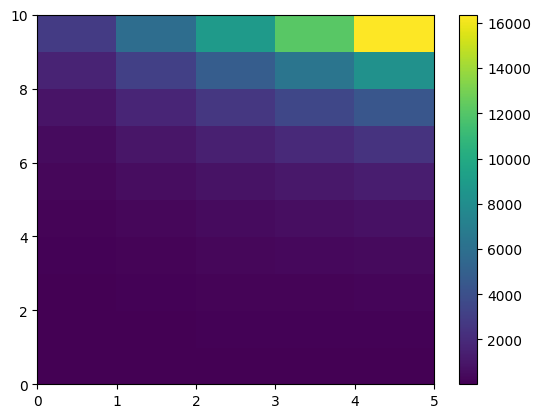

In [222]:
plt.figure()
plt.pcolor(time_delta)
plt.colorbar()

In [220]:
from sklearn.linear_model import LinearRegression

n_meters_, n_days_ = np.meshgrid(n_meters, n_days)
X = np.vstack([n_meters_.ravel(), n_days_.ravel()]).T
Y = time_delta.ravel()
model = LinearRegression().fit(X, Y)

print(model.intercept_)
print(model.coef_)

-3505.6643630268964
[3.52235551 4.30483945]


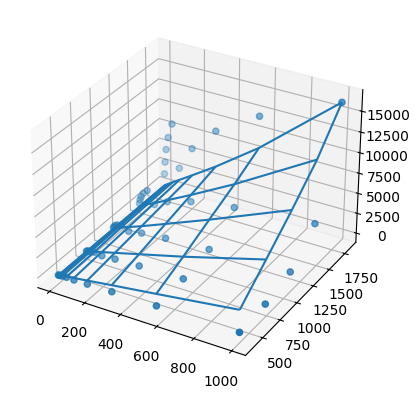

In [221]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], Y)
ax.plot_wireframe(n_meters_, n_days_, time_delta.T)

## Exercise 5: observations after benchmarking

Linear relationship between single variable and time:
- time and number of meters
- time and number of days

Both linear relationships do not stack linearly.

Possible cost calculation improvements:
- Check performance of each step in function cost_table() to focus on most time complex steps first
- Vecorize as much as possible (but being aware about memory cost as trade off)
- Use parallel computing alternatives to pandas, such as Dask
- Benchmark memory consumption as well